In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src')
import black_scholes as bs
import heston as he
import heston_calib as hec
import scipy
from scipy.stats import lognorm
from itertools import product
import pandas as pd
import yfinance as yf
from scipy.optimize import least_squares
from dataclasses import dataclass
from datetime import datetime


# Heston Stochastic Volatility Model

The Heston model captures stochastic variance and the correlation between price and variance shocks.

## Stochastic dynamics under the physical measure

Under the real-world measure $\mathbb{P}$ the dynamics are
$$
\begin{align}
&dS_t = \mu\, S_t\, dt + \sqrt{v_t}\, S_t\, dW_t^{(1)},\\
&dv_t = \kappa(\theta - v_t)\, dt + \sigma \sqrt{v_t}\, dW_t^{(2)}
\end{align}
$$
with correlated sources $d\langle W^{(1)},W^{(2)}\rangle_t = \rho\, dt$.
The parameters of the model are: 

- $\mu$ : real-world drift
- $\kappa$ : mean-reversion speed
- $\theta$ :  long-run variance
- $\sigma$ :  volatility of variance
- $\rho$ :  correlation
- $v_t\ge0$ :  instantaneous variance

A common sufficient condition to avoid negative variances ($v_t<0$) is the so-called Feller condition, $2\kappa\theta>\sigma^2$.
The initial conditions are set by $S_0$ and $v_0$.

The variance process is a Cox–Ingersoll–Ross (CIR) process, and its expectation is known in closed form:
$$
\mathbb{E}[v_t] = v_0 e^{-\kappa t} + \theta \left(1 - e^{-\kappa t}\right).
$$

This shows that:

* $v_t$ mean reverts exponentially toward $\theta$ with speed $\kappa$.  
* For $\kappa t \ll 1$, the variance stays close to its initial value $v_0$:
  $$
  \lim_{\kappa t\to0} \mathbb{E}[v_t] = v_0.
  $$
* For $\kappa t \gg 1$, the expectation approaches the long-run variance:
  $$
  \lim_{\kappa t\to\infty} \mathbb{E}[v_t] = \theta.
  $$

Thus, even though $v_t$ is random, its average evolution is controlled and stable.


## Risk-neutral dynamics and the volatility premium $\lambda_v$

For pricing, move to the risk-neutral measure $\mathbb{Q}$ so discounted prices are martingales:
$$
dS_t = r\, S_t\, dt + \sqrt{v_t}\, S_t\, dW_t^{(1),\mathbb{Q}}.
$$
where $r$ is the risk-free rate.
We introduce a volatility risk premium $\lambda_v$ in the variance process:
$$
dv_t = \kappa^{\mathbb{Q}}\!\left(\theta^{\mathbb{Q}} - v_t\right) dt
      + \sigma \sqrt{v_t}\, dW_t^{(2),\mathbb{Q}},
\qquad
\kappa^{\mathbb{Q}} = \kappa + \lambda_v,\quad
\theta^{\mathbb{Q}} = \frac{\kappa \theta}{\kappa + \lambda_v}.
$$


# Semi-analytic Heston call price

For a European call with strike $K$ and maturity $T$:
$$
C(S_0,K,T)=S_0\,P_1 - e^{-rT} K\,P_2.
$$

The probabilities are
$$
P_1=\tfrac{1}{2}+\frac{1}{\pi}\int_0^\infty
\operatorname{Re}\!\left(
\frac{e^{-iu\log K}}{iu\,F}\,
\phi(u-i;T)
\right)\,du,
\qquad
P_2=\tfrac{1}{2}+\frac{1}{\pi}\int_0^\infty
\operatorname{Re}\!\left(
\frac{e^{-iu\log K}}{iu}\,
\phi(u;T)
\right)\,du,
$$
where $F=S_0 e^{rT}$ is the forward.

The characteristic function of $\log S_T$ under $\mathbb{Q}$ is
$$
\phi(u;t)=
\exp\!\left\{
iu(\log S_0 + r t)
+\frac{\kappa \,\theta}{\sigma^2}
\Big[(\xi-d)t - 2\log\!\Big(\frac{1-g_2 e^{-dt}}{1-g_2}\Big)\Big]
+\frac{v_0}{\sigma^2}(\xi-d)\frac{1-e^{-dt}}{1-g_2 e^{-dt}}
\right\},
$$
with
$$
\xi=\kappa-\sigma\rho\, i u,\qquad
d=\sqrt{\xi^2+\sigma^2(u^2+i u)},\qquad
g_1=\frac{\xi+d}{\xi-d},\quad
g_2=\frac{\xi-d}{\xi+d}=\frac{1}{g_1}.
$$

We note that for option pricing one uses the risk-free measure, namely $\kappa^{\mathbb{Q}}$ and $\theta^{\mathbb{Q}}$.


## Convergence of Monte Carlo prices to the semi-analytic Heston solution

To validate the Monte Carlo (MC) implementation of the Heston model, we compare MC call prices with the semi-analytic Heston formula across a range of strikes. For each strike we compute the relative error
$$
\left|\frac{C_{\mathrm{MC}}}{C_{\mathrm{Anal.}}} - 1\right|,
$$
and estimate statistical uncertainty using the standard error of the Monte Carlo estimator.

The plot shows results for different numbers of simulated paths. Increasing the number of paths reduces variance and improves the agreement with the semi-analytic reference price.


In [29]:
S0=120
T=1.0
v0=0.06
r=0.05
kappa=6.0
theta=0.06
sigmavol=0.8
rho = -0.2 
n_steps=252
N_points = 40
paths_range = [10,1000,100000]
K_range = np.linspace(60,180,N_points)
results = []
for n_paths, K in product(paths_range, K_range):
    value_mc, err_mc = he.heston_call_value_MC(S0, K, v0, r, kappa, theta, sigmavol, rho, T, n_steps, n_paths)
    value_an, err_an = he.heston_call_value(S0, K, v0, r, kappa, theta, sigmavol, rho, T)
    results.append({
        "n_paths": n_paths,
        "K": K,
        "MC": value_mc,
        "Analytic": value_an,
        "MC_err": err_mc,
        "Analytic_err": err_an
    })

df = pd.DataFrame(results)


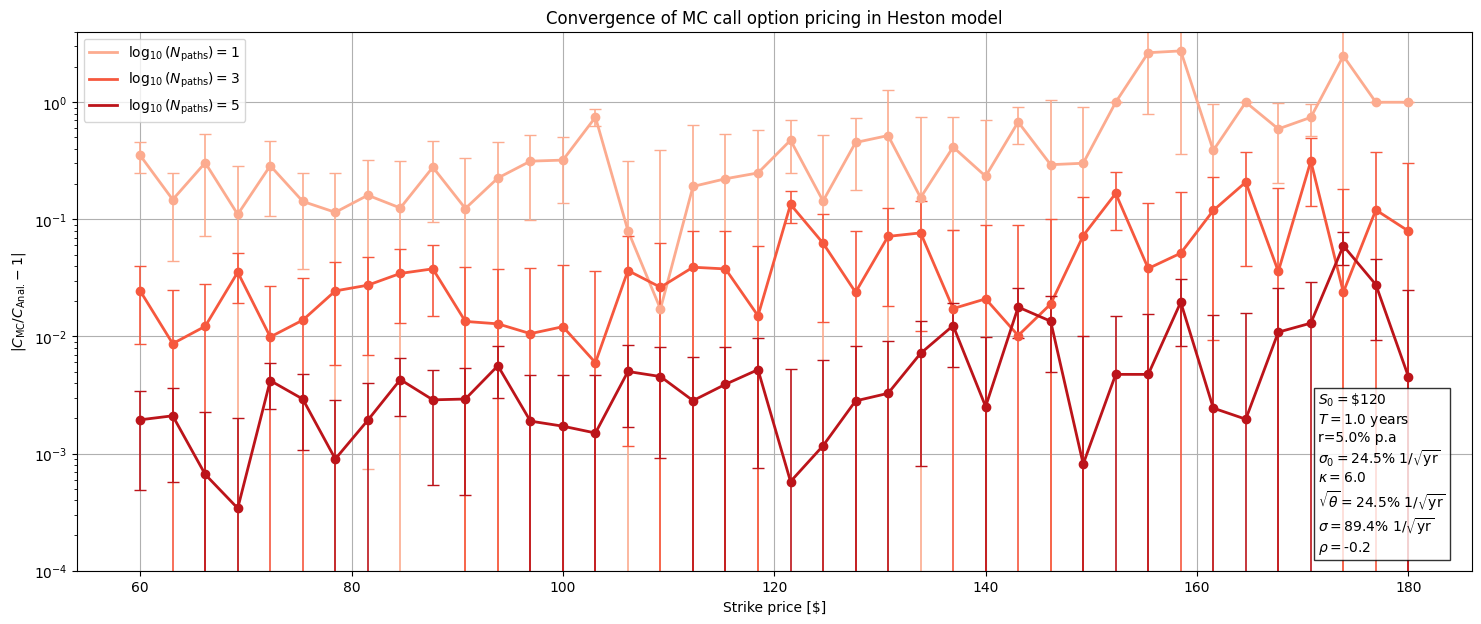

In [37]:
colorsR = [plt.cm.Reds(x) for x in np.linspace(0.3,0.8,3)]

plt.figure(figsize=(18, 7))
# _, ax = plt.subplots()
for i,n_paths in enumerate(paths_range):
    rel_dif = np.abs((df[df["n_paths"] == n_paths]["MC"]-df[df["n_paths"] == n_paths]["Analytic"])/(df[df["n_paths"] == n_paths]["Analytic"]))
    rel_dif_err =  np.abs((df[df["n_paths"] == n_paths]["MC_err"])/(df[df["n_paths"] == n_paths]["Analytic"]))
    plt.plot(K_range,rel_dif,color=colorsR[i],lw=2.,alpha=1.0,label=r"$\log_{10}(N_{\text{paths}})=$"+f"{int(np.log10(n_paths))}")
    plt.errorbar(K_range, rel_dif, yerr=rel_dif_err , lw=3.,fmt='o',alpha=1.0,color=colorsR[i],capsize=4,elinewidth=1.2,capthick=1.0)
plt.yscale('log')
plt.xlabel('Strike price [$]')
plt.ylabel(r'$|C_{\text{MC}}/C_{\text{Anal.}}-1|$')
plt.ylim(1e-4, 4) 
plt.title('Convergence of MC call option pricing in Heston model')
plt.legend()
plt.grid(True)
plt.text(0.89, 0.18, 
         rf'$S_0=\${S0}$'+'\n'+r'$T=$'+f'{T} years'+"\n"+f'r={100*r}% p.a'+"\n"+r'$\sigma_0=$'+f'{np.sqrt(v0)*100:.3}'+r'% $1/\sqrt{\text{yr}}$'
         +'\n'+r'$\kappa=$'+f'{kappa}'+'\n'+r'$\sqrt{\theta} =$'+f'{np.sqrt(theta)*100:.3}'+r'% $1/\sqrt{\text{yr}}$'+ '\n'
         +r'$\sigma=$'+f'{np.sqrt(sigmavol)*100:.3}'+r'% $1/\sqrt{\text{yr}}$'+'\n'+r'$\rho=$'+f'{rho}', 
         fontsize=10, color="black", ha="left", va="center",transform=plt.gca().transAxes,bbox=dict(boxstyle="square", facecolor="white", edgecolor="black",alpha=0.8))

plt.show()


### Interpretation

The convergence trend is clearly visible: the relative pricing error decreases as the number of Monte Carlo paths increases. At $10^5$ paths, errors typically reach the $10^{-3}$ to $10^{-4}$ range, consistent with the expected $1/\sqrt{N_{\mathrm{paths}}}$ behavior of MC estimators. Overall, the MC pricer reproduces the semi-analytic Heston prices well once sufficient paths are used.

# Empirical Analysis of Heston Call Prices and Calibration to Market Data

We now apply the semi-analytic Heston pricing formula to real equity option data for three major stocks: **AMZN**, **GOOG**, and **AMD**.  
For each stock we follow the same structure:

1. Compute call prices across a wide range of strikes and expiries using the Heston model.  
2. Calibrate Heston parameters to option-chain data for short-term and long-term expiries.  
3. Examine the relative pricing error  
   $$
   \left|\frac{C_{\mathrm{Heston}}}{C_{\mathrm{Data}}}-1\right|
   $$
   as a function of strike.

A vertical dashed line indicates the at-the-money (ATM) strike, serving as a reference point across maturities.

---

# AMZN

## Heston call prices for AMZN

The following plot shows Heston call prices as a function of strike for a range of expiries.  
Short-term expiries (blue) produce steeper curves, since near-term options have less time value and are more sensitive to moneyness.  
Long-term expiries (red) are smoother and more elevated due to increased discounted expectation of future volatility.

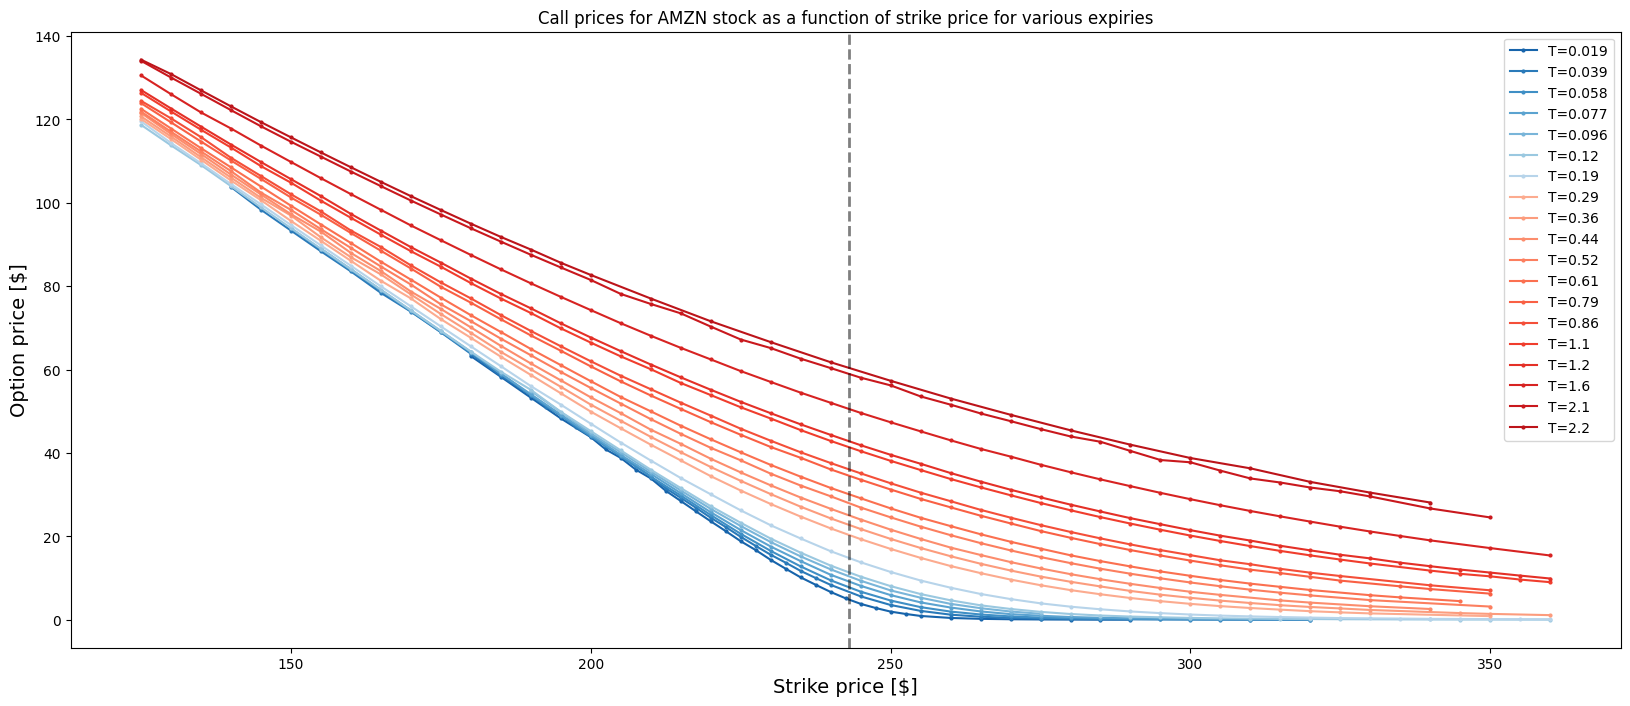

In [2]:
data_AMZN_short = hec.load_option_chain("AMZN",0.01,0.25)
data_AMZN_long = hec.load_option_chain("AMZN",0.25,3)

hec.plot_option_price([data_AMZN_short,data_AMZN_long],[lambda x:plt.cm.Blues(x),lambda x:plt.cm.Reds(x)])

## Calibration to AMZN option data

We separately calibrate the Heston model to short-dated and long-dated AMZN options.  
Short maturities typically load more heavily on the volatility-of-volatility and mean reversion-rate parameters.

The plot below shows the relative error between Heston model prices and market mid-prices across strikes.  
The fitted parameters are of the order of magnitude expected from the Heston model:

- Deep ITM : Errors remain mostly between $10^{-3}$ and $10^{-2}$ for both long- and short-term options.
- Deep OTM : Erros remain mostly low for long-term option, while OTM short-term options become almost worthless and thus more susceptible to mismodeling, with mispricing still only at the 10% level.

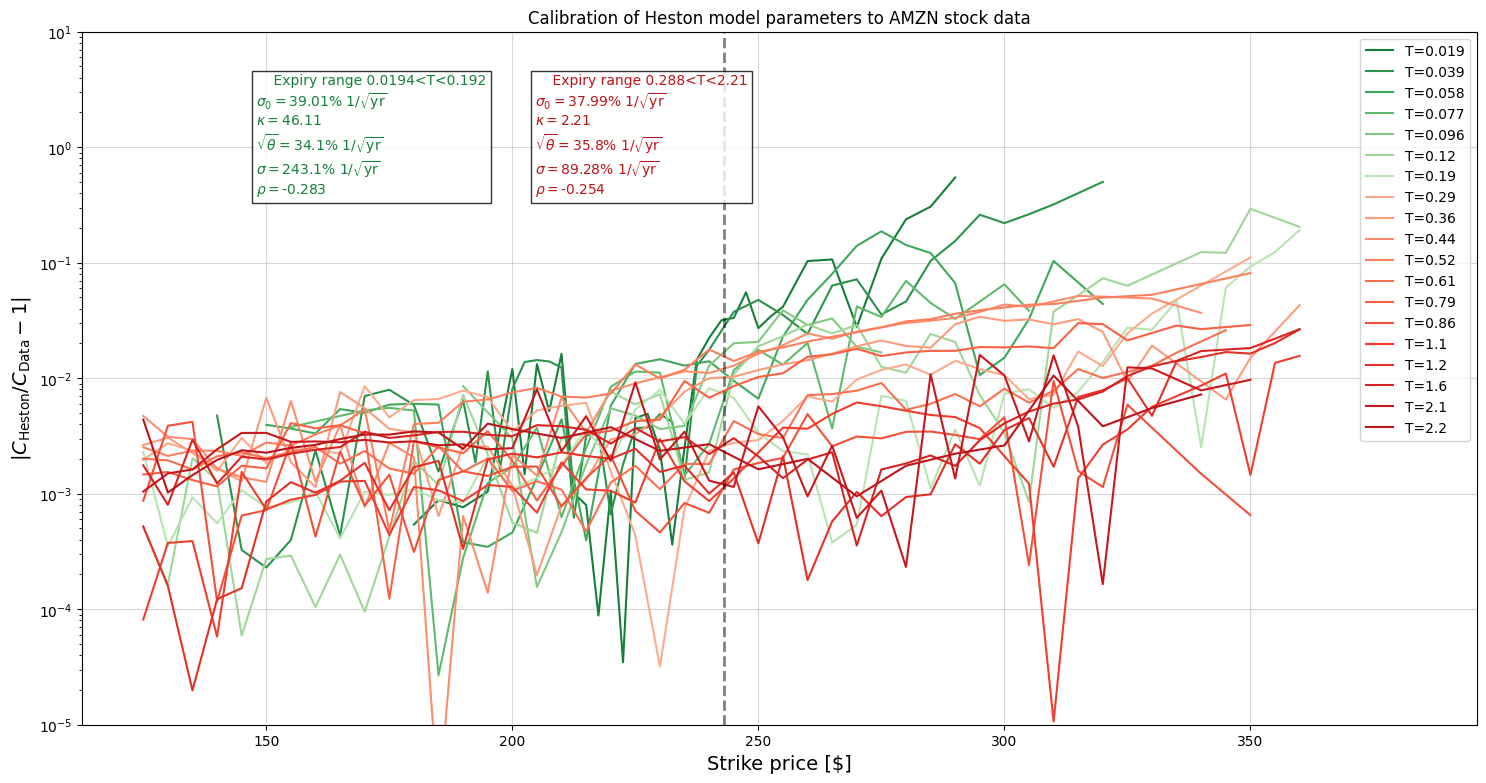

In [3]:
x0 = np.array([5.0, 0.04, 2.0, -0.5, 0.04])  # [kappa, theta, xi, rho, sigma0]
bounds = (
    [1e-6, 1e-6, 1e-6, -0.999, 1e-6],  # lower
    [1000.0, 2.0, 10.0,   +0.999,  2.0]    # upper
)

AMZN_long_cal = hec.calibrate_heston(data_AMZN_long,x0,bounds)
AMZN_short_cal = hec.calibrate_heston(data_AMZN_short,x0,bounds)
hec.plot_calibration([data_AMZN_short,data_AMZN_long],[AMZN_short_cal,AMZN_long_cal],[lambda x:plt.cm.Greens(x),lambda x:plt.cm.Reds(x)])

# GOOG

## Heston call prices for GOOG


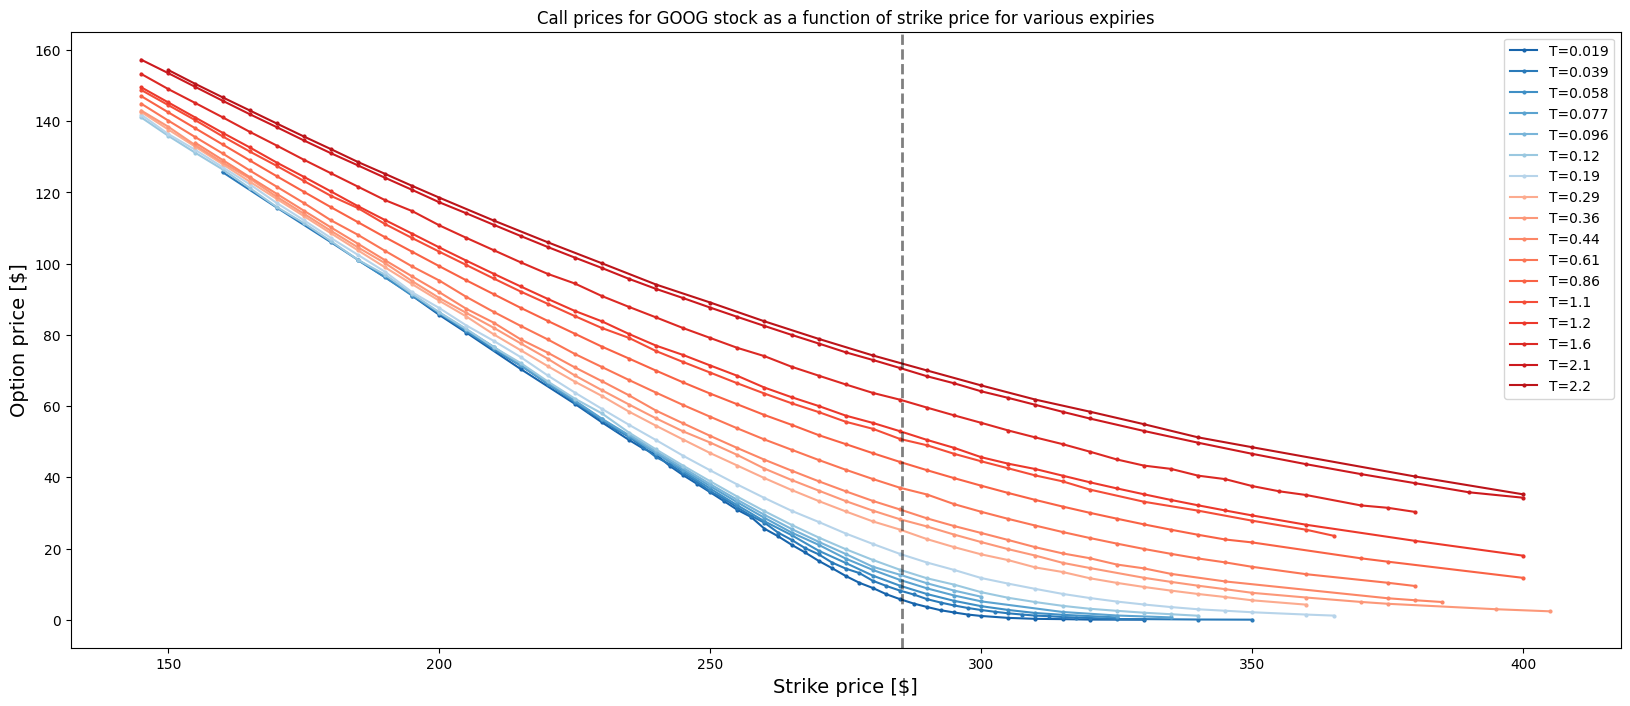

In [5]:
data_GOOG_short = hec.load_option_chain("GOOG",0.01,0.25)
data_GOOG_long = hec.load_option_chain("GOOG",0.25,3)

hec.plot_option_price([data_GOOG_short,data_GOOG_long],[lambda x:plt.cm.Blues(x),lambda x:plt.cm.Reds(x)])

## Calibration to GOOG option data

We find slightly different parameters compared to AMZN but similar trends:

- Short-term option require larger vol-of-vol and larger mean reversion rate, reflecting a more jump-like behaviour.
- Long-term option present a smoother behaviour of vol-of-vol with smaller mean reversion rate.
- Good  fit for long-term option in both ITM and OTM regions.
- Good fit for ITM short-term options, model breaks down for extremely short-term optiona. 


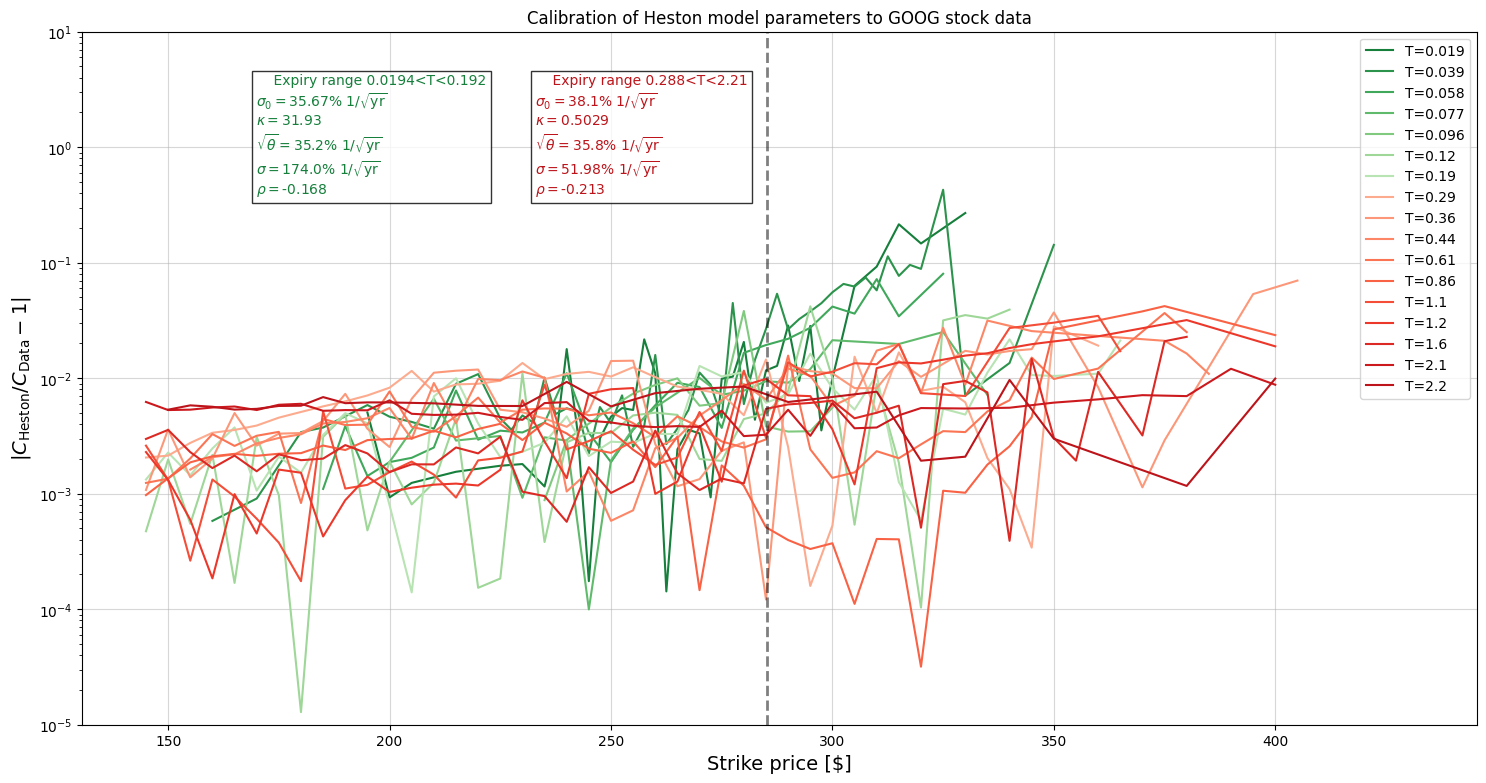

In [6]:

x0 = np.array([5.0, 0.04, 1.0, -0.5, 0.04])  # [kappa, theta, xi, rho, sigma0]
bounds = (
    [1e-6, 1e-6, 1e-6, -0.999, 1e-6],  # lower
    [1000.0, 2.0, 10.0,   0.999,  2.0]    # upper
)

GOOG_long_cal = hec.calibrate_heston(data_GOOG_long,x0,bounds)
GOOG_short_cal = hec.calibrate_heston(data_GOOG_short,x0,bounds)
hec.plot_calibration([data_GOOG_short,data_GOOG_long],[GOOG_short_cal,GOOG_long_cal],[lambda x:plt.cm.Greens(x),lambda x:plt.cm.Reds(x)])

# AMD

## Heston call prices for AMD

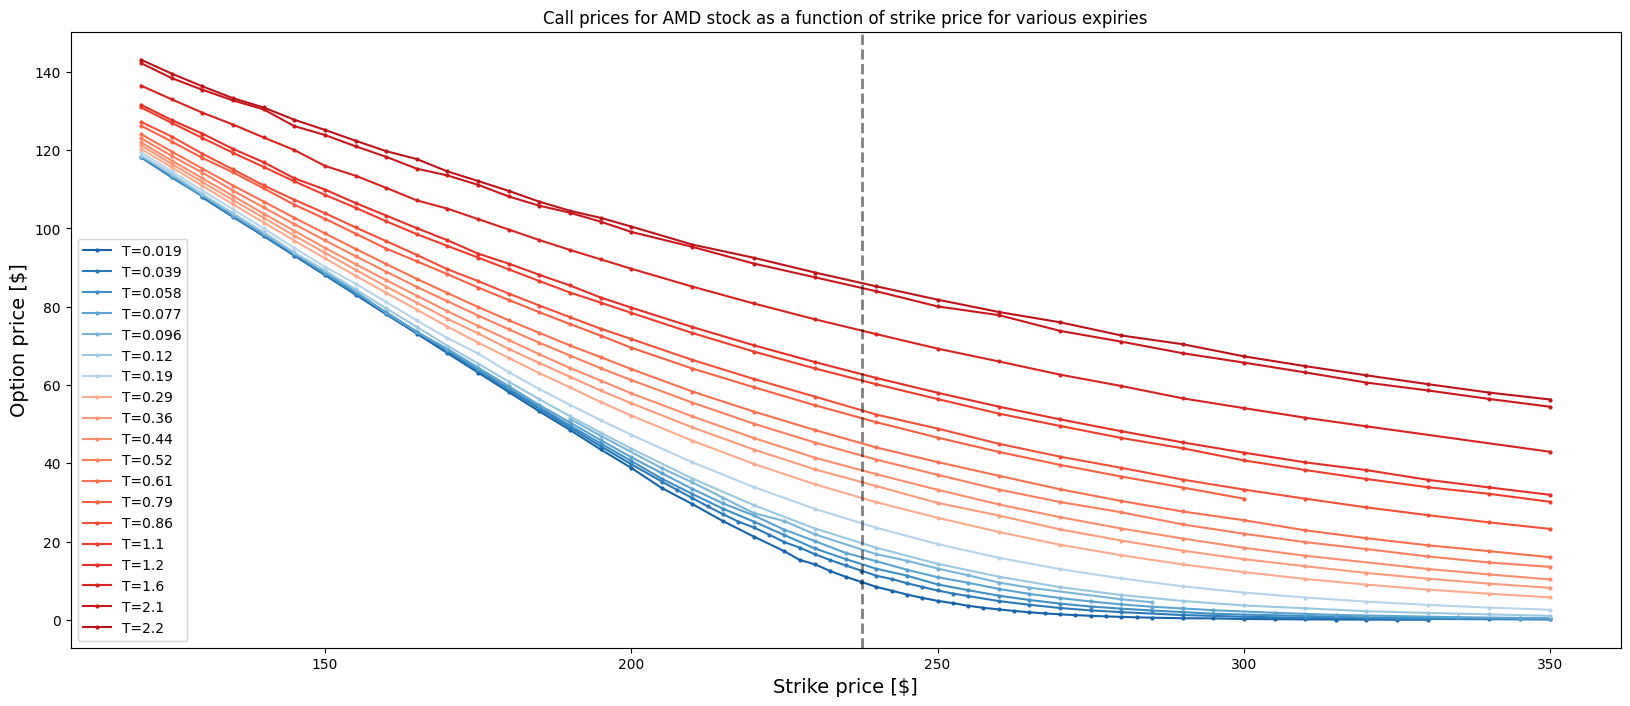

In [8]:
data_AMD_short = hec.load_option_chain("AMD",0.01,0.25)
data_AMD_long = hec.load_option_chain("AMD",0.25,3)

hec.plot_option_price([data_AMD_short,data_AMD_long],[lambda x:plt.cm.Blues(x),lambda x:plt.cm.Reds(x)])


## Calibration to AMD option data

We find similar trends as for AMZM and GOOG.

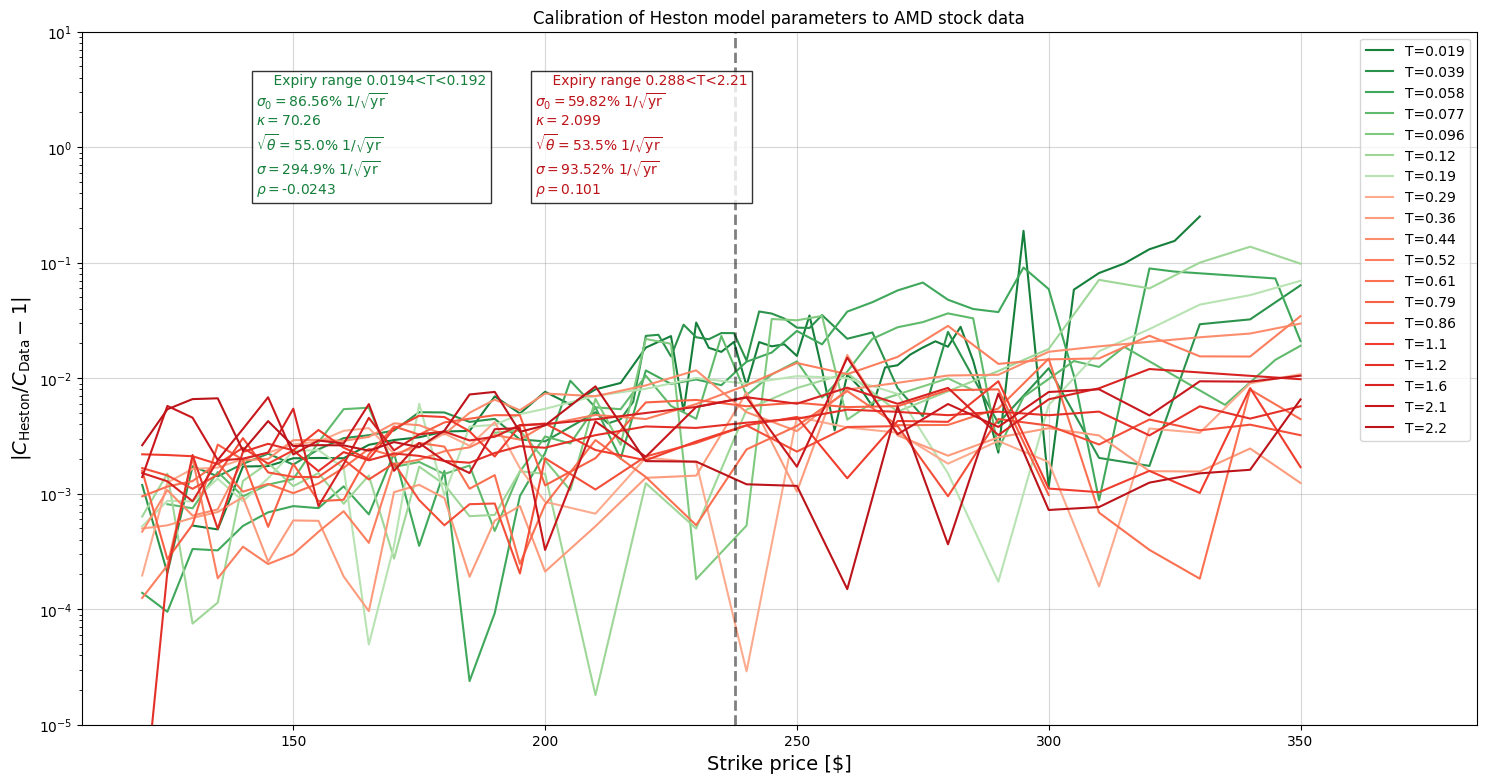

In [9]:

x0 = np.array([5.0, 0.04, 1.0, -0.5, 0.04])  # [kappa, theta, xi, rho, sigma0]
bounds = (
    [1e-6, 1e-6, 1e-6, -0.999, 1e-6],  # lower
    [1000.0, 2.0, 10.0,   0.999,  2.0]    # upper
)

AMD_long_cal = hec.calibrate_heston(data_AMD_long,x0,bounds)
AMD_short_cal = hec.calibrate_heston(data_AMD_short,x0,bounds)
hec.plot_calibration([data_AMD_short,data_AMD_long],[AMD_short_cal,AMD_long_cal],[lambda x:plt.cm.Greens(x),lambda x:plt.cm.Reds(x)])

# Discussion

### Short-term vs long-term expiries: qualitative differences in fitted Heston parameters

When calibrating the Heston model separately to short-dated and long-dated option expiries, we consistently observe systematic differences in the estimated parameters. This pattern appears across all three stocks (AMZN, GOOG, AMD) and reflects the different market dynamics that dominate near expiry compared with those that influence long-horizon option prices.

#### Short-term expiries (near maturity)
Short-dated options are mostly driven by **local, immediate fluctuations in volatility**.  
As a result, calibrations on short maturities tend to favor:

* **Large volatility of volatility** ($\sigma$):  
  Short-term implied vol responds strongly to instantaneous shocks.  
  A larger $\sigma$ gives the model enough flexibility to match the steep short-term skew.

* **Large mean-reversion speed** ($\kappa$):  
  Over very short horizons, variance is perceived to revert quickly toward its current level.  
  A large $\kappa$ produces the tight anchoring required by short-term smiles.


Together, large $\kappa$ and large $\sigma$ describe volatility that fluctuates aggressively but snaps back quickly, consistent with the sharp shape of short-dated implied volatility smiles.

#### Long-term expiries (far maturity)
Long-dated options are governed by **average long-run behavior** of the variance process.  
Hence long-expiry calibrations tend to yield:

* **Smaller volatility of volatility** ($\sigma$):  
  High-frequency variance shocks are averaged out over long horizons.  
  Markets care more about long-run variance levels than daily fluctuations.

* **Smaller mean-reversion speed** ($\kappa$):  
  Long-term prices allow variance to drift more slowly.  
  Lower $\kappa$ reflects a smoother, long-horizon volatility environment.


These shifts reflect that long-term implied volatilities encode structural uncertainty and macro-level variance behavior, rather than fast, local shocks.
Unlike $\kappa$ and $\sigma$, the behavior of $\rho$ across maturities is **not consistent** in our calibrations and should be interpreted with caution.
In practical calibration, the parameters $\rho$, $\sigma$ and $\kappa$ may exhibit what is essentially a **flat direction in parameter space**. This means that different combinations of these parameters produce almost the same implied–volatility smile, so the objective function (pricing error) is nearly unchanged along certain parameter combinations.



# Summary

Across AMZN, GOOG, and AMD:

* Heston call-price curves produce realistic shapes that interpolate smoothly across maturities.  
* Calibration fits short-term and long-term expiries reasonably well, though they naturally produce differing parameter sets.  
* Relative pricing errors remain small, typically between $10^{-3}$ and $10^{-2}$, validating both the semi-analytic pricer and the calibration pipeline.

This completes the empirical evaluation of the Heston model on real option-chain data.

# Hedging a European Call Option in the Heston Model

We now consider hedging a European call option using a discrete-time rebalancing strategy.  
Throughout this section we follow the following portfolio conventions:

* we are **long** one unit of the target call $C(S,v)$ (with strike price $K_C$ and expiry $T_C$),  
* we are **short** $\Delta$ units of the underlying stock $S$,  
* we are **short** $\phi$ units of another call option $H(S,v)$ used as an additional hedging instrument (with strike price $K_H$ and expiry $T_H$).

The trading portfolio is therefore
$$
\Pi_t = C_t - \Delta_t S_t - \phi_t H_t.
$$
Rebalancing occurs **discretely** at times
$$
0 = t_0 < t_1 < \cdots < t_{n-1} < t_n = T,
$$
with step size $\Delta t = t_i - t_{i-1}$.
We require
$$
\begin{align*}
(\Pi_t)_{S_t} &= (C_t)_{S_t} - \Delta_t- \phi_t (H_t)_{S_t} \stackrel{!}{=} 0
\\
(\Pi_t)_{v_t} &= (C_t)_{v_t}- \phi_t (H_t)_{v_t} \stackrel{!}{=} 0
\end{align*}
$$
where $(X)_{Y} \equiv \partial X/\partial Y$. These equations are solved by
$$
\begin{align*}
\phi_t& = \frac{(C_t)_{v_t}}{ (H_t)_{v_t}}\,,
\\
\Delta_t&= (C_t)_{S_t}- \phi_t (H_t)_{S_t} = (C_t)_{S_t}- \frac{(C_t)_{v_t}}{ (H_t)_{v_t}}  (H_t)_{S_t}\,,
\end{align*}
$$
which we calculate at each time $t$ using the Heston greeks. At each rebalancing time, the hedge ratios change by
$$
\delta\Delta_i = \Delta_i - \Delta_{i-1},  
\qquad
\delta\phi_i = \phi_i - \phi_{i-1},
$$
and these adjustments generate cashflows proportional to the current asset values $S_i$ and $H_i$.
Each cashflow must be discounted according to the time it occured, and the final portfolio must also account for the cost of closing the positions in $S$ and $H$ at the end of the horizon.

Putting everything together, the total discounted P&L of the hedging strategy is
$$
\mathbb{P}(\Pi_T)
=
-\;P_{C_0}\;+\;\Delta_0 S_0\;+\;\phi_0 H_0
\;+\;
\sum_{i=1}^{n-1} 
(\delta\Delta_i S_i + \delta\phi_i H_i)\, e^{-r\, i\Delta t}
\;+\;
e^{-rT}
\left[
V(S_n,T)\;-\;\Delta_{n-1} S_n\;-\;\phi_{n-1} H_n
\right].
$$

Here $V(S_n,T)$ is the payoff of the call $C$ at maturity and $P_{C_0}$ is the premium paid for $C$ at initiation. 
For our simulation, we use the Heston meson pricing for $P_{C_0}$; we therefore expect that if hedged correctly, the P&L distribution should be centered around 0, namely the option is correctly priced independently of the physical measure parameters.
In order to allow hedging against volatility fluctuation until the expiry of $C$, we take $T_H \geq T_C$.

This expression gives the full end-of-horizon hedging P&L for any discrete-time rebalancing scheme under the Heston model.


## Effect of Delta and Vega Hedging on Portfolio P&L

To illustrate the qualitative impact of hedging in the Heston model, we compare the distribution of discounted P&L under three strategies:

- **No hedging**: the portfolio is left unprotected against movements in the underlying and in volatility.
- **Delta hedging only**: we neutralize the first-order exposure to the underlying price but retain full exposure to volatility shocks.
- **Delta + Vega hedging**: we neutralize both the first-order exposure to the underlying and the first-order exposure to instantaneous variance.

The histogram below shows the resulting P\&L distributions (log-scale density).  
A few salient observations emerge:

- **No hedging** leads to a very wide P\&L distribution, with large gains and large losses — as expected for an unhedged option position.
- **Delta hedging alone** reduces some of the extreme variation and protects against complete loss of initial permium, but significant dispersion remains due to volatility risk.
- **Delta + Vega hedging** dramatically tightens the distribution: both the variance and the left-tail risk collapse by more than an order of magnitude.
- The **mean P\&L is nearly zero** for the Delta+Vega strategy, reflecting that the option is accurately priced under the considered model.

This plot provides a clear visual demonstration of how hedging progressively suppresses risk arising from the different stochastic drivers of the Heston model.


In [32]:
params = he.HestonParams(
    S0 = 100,
    v0 = 0.4**2,
    mu = 0.05,
    r = 0.08,
    KC = 95,
    KH = 105,
    TC = 0.25,
    TH = 1.0,
    eps = 1e-3,
    u_max = 200,
    n_u = 1000,
    kappa = 9.5,
    theta = 0.35**2,
    lambda_v = 0.0,
    sigmavol = 0.8,
    rho = -0.2,
    n_steps = 63, #daily for T=0.25
    n_paths = 1000
)


In [4]:
PnL_no_hedge,PnL_delta,PnL,df = he.heston_hedging(params)

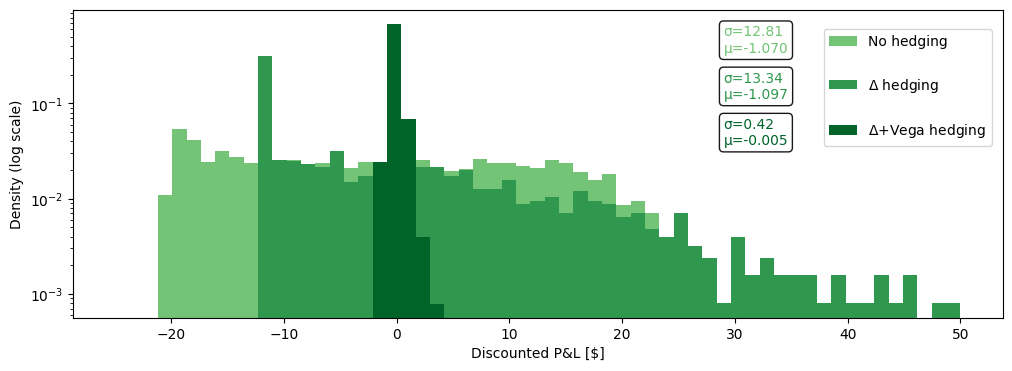

In [28]:
PnLs = [PnL_delta,PnL_no_hedge,PnL]
labels = ['No hedging',r'$\Delta$ hedging',r'$\Delta$+Vega hedging']
mincolor = 0.5
maxcolor= 0.9
colors = [plt.cm.Greens(x) for x in np.linspace(mincolor,maxcolor,len(PnLs ))]
fig, ax = plt.subplots(figsize=(12, 4))
bins = np.linspace(-25, +50, 60)
for i,r in enumerate(PnLs):
    ax.hist(r,bins=bins,color=colors[i],label=labels[i],density='true')
    ax.text(
        0.70, 0.95-i*0.15,                      # (x, y) in 0–1 coordinates
        f"σ={r[~np.isnan(r)].std():.2f}"+'\n'+ f"μ={r[~np.isnan(r)].mean():.3f}",
        ha="left", va="top",
        fontsize=10,
        color=colors[i],
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9),
        transform=ax.transAxes           # <<< key line
    )
ax.set_yscale("log")  
ax.set_xlabel("Discounted P&L [$]")
ax.set_ylabel("Density (log scale)") 
ax.legend(loc="upper left", bbox_to_anchor=(0.8, 0.96),labelspacing=2.0)
plt.show()

## Distribution of Hedging P&L Under Different Re-Hedging Frequencies

Having derived the discrete-time P&L expression for our hedging strategy, we now study how the **hedging error** behaves as we change the re-hedging frequency.  
In continuous time, a perfectly calibrated Heston-model delta hedge would eliminate all risk.  
In practice, we rebalance at discrete intervals, and this introduces **gamma**, **vega**, and **correlation-induced cross-gamma** risk terms, all of which accumulate into a non-zero P&L distribution:

$$
\begin{align*}
\delta \Pi = \left(\frac12 \Pi_{SS}S^2 v +\frac12 \Pi_{vv}\sigma^2 v+\Pi_{vS}\rho\,\sigma\,v\,S\right) \Delta t 
\end{align*}
$$

To quantify this effect, we simulate 1000 Heston paths and compute the discounted hedging P&L for three rebalancing intervals:

- **18.2 days** (very infrequent rebalancing)  
- **1.8 days** (daily-scale rebalancing)  
- **0.2 days** (near-continuous rebalancing)

The histograms below show the resulting P&L distributions on a log-density scale.  
As expected, coarser hedging leads to much larger dispersion.


In [ ]:
# res = []
# n_steps_range = np.array([5,50,500])
# for n_step in n_steps_range:
#     cur_params = params
#     params.n_steps = n_step
#     PnL_no_hedge,PnL_delta,PnL,df = he.heston_hedging(cur_params)
#     res.append(PnL)
# res = np.array(res)
# np.save("res_heston.npy", res)

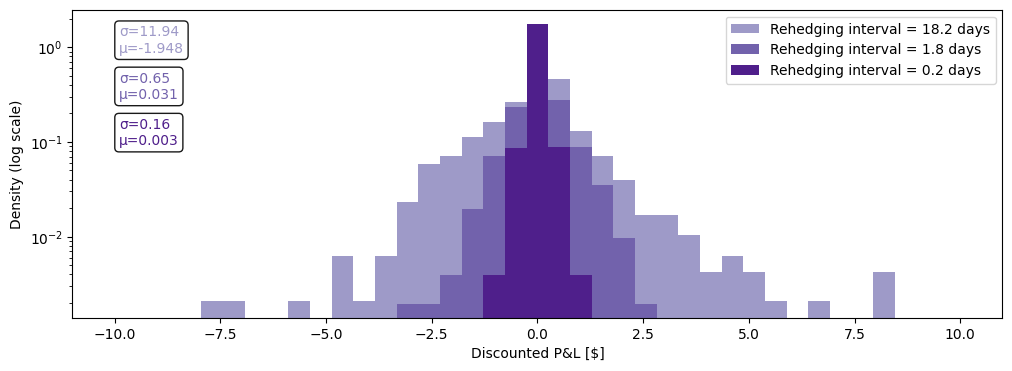

In [7]:
heston_hedge_freq = np.load("results/heston_hedge_freq.npy", allow_pickle=True)
n_steps_range = np.array([5,50,500])
mincolor = 0.5
maxcolor= 0.9
colors = [plt.cm.Purples(x) for x in np.linspace(mincolor,maxcolor,len(heston_hedge_freq ))]
fig, ax = plt.subplots(figsize=(12, 4))
bins = np.linspace(-10, +10, 40)
for i,r in enumerate(heston_hedge_freq):
    ax.hist(r,bins=bins,color=colors[i],label=f'Rehedging interval = {365*0.25/n_steps_range[i]:.1f} days',density='true')
    ax.text(
        0.05, 0.95-i*0.15,                      # (x, y) in 0–1 coordinates
        f"σ={r[~np.isnan(r)].std():.2f}"+'\n'+ f"μ={r[~np.isnan(r)].mean():.3f}",
        ha="left", va="top",
        fontsize=10,
        color=colors[i],
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9),
        transform=ax.transAxes           # <<< key line
    )
ax.set_yscale("log")  
ax.set_xlabel("Discounted P&L [$]")
ax.set_ylabel("Density (log scale)") 
ax.legend()
plt.show()

### Interpretation

The figure shows a clear sharpening of the hedging P&L distribution as the rebalancing frequency increases.

- **Wide interval (18.2 days):**  
  The distribution is extremely dispersed, with a standard deviation of nearly 12 dollars.  
  This reflects the accumulation of unhedged gamma and vega exposure between rebalancing dates.  
  The small negative mean (≈ –1.95) is common: coarse hedging systematically loses money because the convexity (i.e. positivity of the second derivatives) of the option works against you when you rebalance infrequently.

- **Moderate interval (1.8 days):**  
  The variance drops by more than an order of magnitude (σ ≈ 0.65).  
  This corresponds to near-daily hedging and captures the fact that most short-term gamma shocks are neutralized before they can accumulate.

- **High-frequency interval (0.2 days):**  
  The distribution becomes extremely narrow (σ ≈ 0.16) and nearly centered at zero (mean ≈ 0.003).  
  As rebalancing becomes continuous, the expected hedging error approaches zero and its variance collapses.

In [30]:
kappa_vals = [10,50,100]
sigmavol_vals = [0.5,1.0,2.0]
lambda_v_range = np.sort(np.concatenate([np.linspace(-0.9, 0.9, 20), [0]]))
theta = 0.5**2
for kappa in kappa_vals:
    for sigmavol in sigmavol_vals:
        if (2*theta*kappa-sigmavol**2<0):
            print(f'\u2718 Feller condition FAILED for kappa={kappa} and sigmavol={sigmavol}')
        else:
            print(f'\u2714 Feller condition passed for kappa={kappa} and sigmavol={sigmavol}')

✔ Feller condition passed for kappa=10 and sigmavol=0.5
✔ Feller condition passed for kappa=10 and sigmavol=1.0
✔ Feller condition passed for kappa=10 and sigmavol=2.0
✔ Feller condition passed for kappa=50 and sigmavol=0.5
✔ Feller condition passed for kappa=50 and sigmavol=1.0
✔ Feller condition passed for kappa=50 and sigmavol=2.0
✔ Feller condition passed for kappa=100 and sigmavol=0.5
✔ Feller condition passed for kappa=100 and sigmavol=1.0
✔ Feller condition passed for kappa=100 and sigmavol=2.0


In [ ]:
# print(datetime.now())
# for kappa in kappa_vals:
#     for sigmavol in sigmavol_vals:

#         filename = f"results/heston_{kappa}_{sigmavol}.npy"
#         if os.path.exists(filename):
#             print(f"Skipping kappa={kappa}, sigmavol={sigmavol} (file exists)")
#             continue

#         cur_params = params
#         cur_params.theta = theta
#         cur_params.kappa = kappa
#         cur_params.sigmavol = sigmavol

#         res = []
#         for lambda_v in lambda_v_range:
#             cur_params.lambda_v = lambda_v * kappa
#             PnL_no_hedge, PnL_delta, PnL, df = he.heston_hedging(cur_params)
#             res.append(PnL)

#         res_lambda_v = np.array(res)
#         np.save(filename, res_lambda_v)
#         print(datetime.now())
#         print(f"kappa={kappa} and sigmavol={sigmavol} done!")

In [46]:
results = []

for kappa in kappa_vals:
    for sigmavol in sigmavol_vals:
        
        fname = f"results/heston_{kappa}_{sigmavol}.npy"
        arr = np.load(fname, allow_pickle=True)

        cur_params = params
        cur_params.theta = theta
        cur_params.kappa = kappa
        cur_params.sigmavol = sigmavol

        for i, PnL_raw in enumerate(arr):

            # --- Clean NaNs ---
            PnL = np.asarray(PnL_raw)
            PnL = PnL[~np.isnan(PnL)]

            # Skip bad entries
            if len(PnL) == 0:
                continue

            mean = np.mean(PnL)
            std = np.std(PnL)
            mse = std**2 + mean**2   # = E[X^2]
            call_value,_ = he.heston_call_value_vectorized(cur_params.S0, cur_params.KC, cur_params.v0, cur_params.r , kappa, theta, sigmavol,cur_params.rho, cur_params.TC)
            results.append({
                "kappa": kappa,
                "sigmavol": sigmavol,
                "lambda_v": lambda_v_range[i] * kappa,
                "mean": mean,
                "mean_error": std/np.sqrt(len(PnL)),
                "std": std,
                "std_error": std/np.sqrt(2*(len(PnL)-1)),
                "MSE": mse,
                "call_value": call_value,
                "n_samples": len(PnL)
            })

df = pd.DataFrame(results)
df = df.sort_values(["kappa", "sigmavol", "lambda_v"]).reset_index(drop=True)


### Hedged P&L mean (normalized by option value)

We would like to explore how the hedging preforms under different dynamics of the physical system. We do so by considering several combinations of $\kappa \in \{10, 50, 100\}$ and $\sigma_v \in \{0.5, 1.0, 2.0\}$, keeping $\theta$ fixed, and varying the risk premium $\lambda_v$.  For every fixed risk-free measure parameters $\kappa,\theta$, the physical measure parameters are given
$$
\begin{align*}
& \kappa^{\mathbb{P}}  = \kappa-\lambda_v,\quad
\\
&\theta^{\mathbb{P}} = \theta\kappa/( \kappa-\lambda_v)\,.
\end{align*}
$$

Note that sense $\kappa\theta = \kappa^{\mathbb{P}}\theta^{\mathbb{P}}$, satifiying the Feller condition in the risk-free measure $2\kappa\theta>\sigma^2$ ensures it is satified in any physical frame with $\lambda_v<\kappa$.

The following plot show the **absolute mean hedged P&L** divided by the **Heston call price** as a function of the volatility-risk-premium parameter $\lambda_v / \kappa_Q$. 
Normalizing by the option price lets us compare hedging error on a **relative** scale, independent of the premium.

**Key observations**
- For small vol-of-vol values ($\sigma_v \in \{0.5, 1.0\}$), the normalized mean error typically lies around $10^{-3}$–$10^{-2}$ with only mild dependence on $\lambda_v$.
- In the extreme regime $\sigma_v = 2.0$, discretization errors are larger and the dependence on $\lambda_v$ becomes visible since the discretization erros depend on the evolution in the physical measure. This is espicially true for the smalles value of $\kappa$ in which the system is dominated by the vol-of-vol, leading to the largest discretization error. Efficient hedging under these dynamics would require a higher re-hedging frequency.

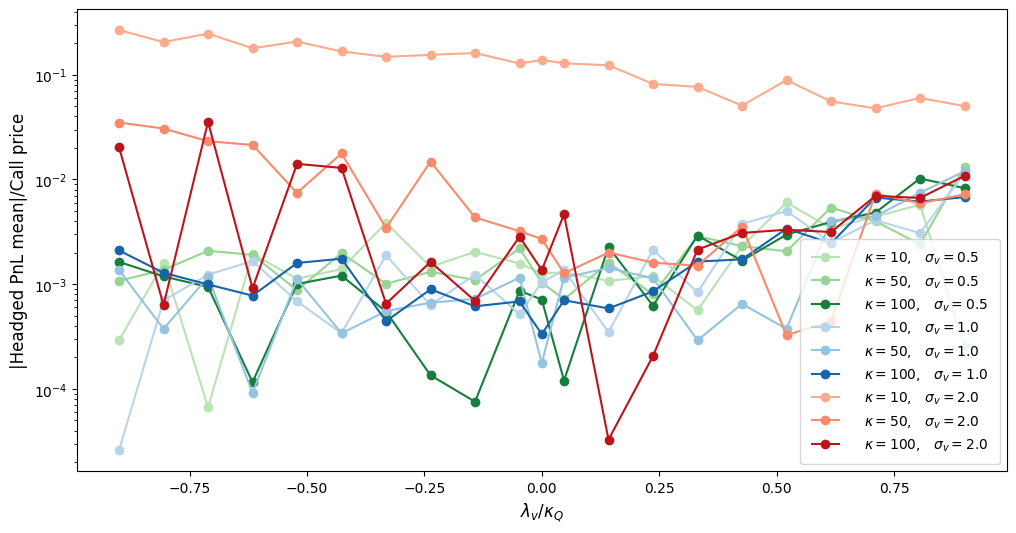

In [54]:
colors = [
    [ plt.cm.Greens(0.3), plt.cm.Blues(0.3), plt.cm.Reds(0.3)],
    [ plt.cm.Greens(0.4), plt.cm.Blues(0.4),plt.cm.Reds(0.4)],
    [ plt.cm.Greens(0.8), plt.cm.Blues(0.8),plt.cm.Reds(0.8)]
]
fig, ax = plt.subplots(figsize=(12, 6))
for isig,sigmavol in enumerate(sigmavol_vals):
    for ik,kappa in enumerate(kappa_vals):
        mask = (df['kappa']==kappa) & (df['sigmavol']==sigmavol )
        ax.plot(lambda_v_range,np.abs((df[mask])['mean'])/((df[mask])['call_value']),label=fr'$\kappa=${kappa},   $\sigma_v=${sigmavol}',color=colors[ik][isig],marker='o')
        # ax.errorbar(lambda_v_range, np.abs((df[mask])['mean']), yerr=(df[mask])['mean_error'] , lw=3.,fmt='o',alpha=1.0,color=colors[ik][isig],capsize=4,elinewidth=1.2,capthick=1.0)
ax.legend(handletextpad=1.8, borderpad=0.8)
ax.set_xlabel(r"$\lambda_v/\kappa_Q$",fontsize = 12)
ax.set_ylabel("|Headged PnL mean|/Call price",fontsize = 12) 
ax.set_yscale("log")  
plt.show()


### Hedged P&L standard deviation (normalized by option value)

Here we show the **standard deviation** of hedged P&L divided by the **Heston call price** for the same grid.

**Interpretation**
- Relative hedging risk increases with $\sigma_v$, reflecting stronger gamma/vega and $\rho$ cross-terms in the discretization error.
- For $\sigma_v \in \{0.5, 1.0\}$, the normalized P&L std is typically between $5\times 10^{-2}$ and $2\times 10^{-1}$ and is fairly flat in $\lambda_v$.
- For $\sigma_v = 2.0$, residual variance can approach order one because volatility paths are much rougher, so unhedged quadratic variation is larger.

Overall, for realistic vol-of-vol levels ($\sigma_v \le 1$), the **relative** hedging error is small — often well below 1% of the option’s premium. Only very large $\sigma_v$ produces notable degradation.

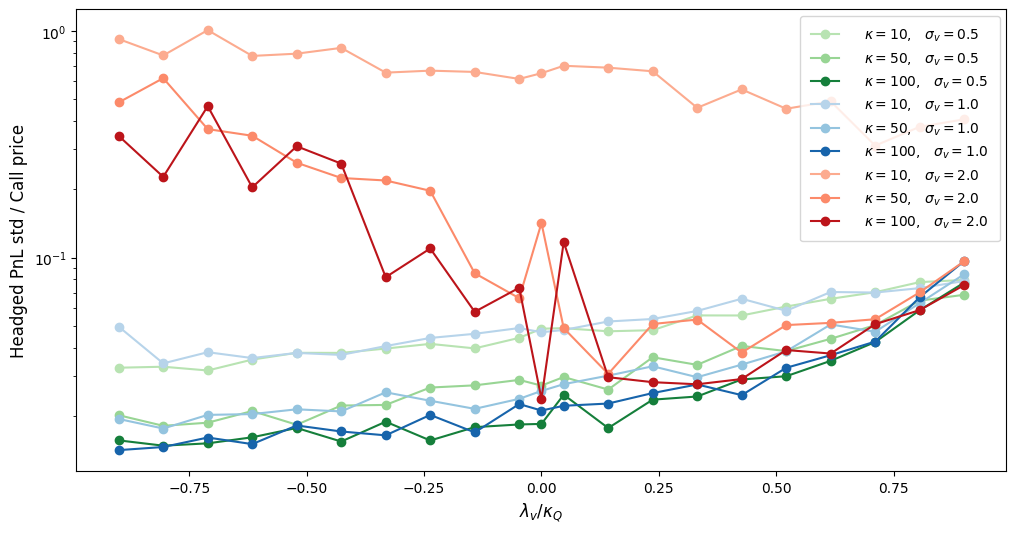

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
for isig,sigmavol in enumerate(sigmavol_vals):
    for ik,kappa in enumerate(kappa_vals):
        mask = (df['kappa']==kappa) & (df['sigmavol']==sigmavol )
        ax.plot(lambda_v_range,(df[mask])['std']/(df[mask])['call_value'],label=fr'$\kappa=${kappa},   $\sigma_v=${sigmavol}',color=colors[ik][isig],marker='o')
ax.legend(handletextpad=1.8, borderpad=0.8)
ax.legend(handletextpad=1.8, borderpad=0.8)
ax.set_xlabel(r"$\lambda_v/\kappa_Q$",fontsize = 12)
ax.set_ylabel("Headged PnL std / Call price",fontsize = 12) 
ax.set_yscale("log")  
plt.show()


### Hedged P&L summary

- For low values vol-of-vol, the re-hedging frequency chosen was sufficient to efficiently hedge the profile independently of $\lambda_v$, namely independently of the evolution of the physical system. The P&L mean (which we can interpreate as estimate for the option price shifted by the Heston model price) remains very close to zero (at the $10^{-3}-10^{-2}$ level) while the error is at the order of a few percents.
- High vol-of-vol models ehibit, as expected, larger discretization errors which in general are path-dependend and therefore $\lambda_v$-dependent. For the edge case of $\lambda_v=2.0$ and $\kappa=5$, the variation in the real-world dynamics is not significant enough to have an effect on the discretization error.
- When the mean reversion rate in the real-world measure was sufficiently small (as $\lambda_v/\kappa$ approaches 1), almost all models display efficient hedging with $<10$% relative error on the option price and sub-precent error on the price. 

## Project summary

**Goal.** Calibrate Heston to option surfaces (AMZN, GOOG, AMD) and study discrete-time hedging performance when Greeks are computed under the risk-neutral measure $Q$ while the underlying follows $P$ set by the volatility risk premium $\lambda_v$.

**Calibration.**
- Short-maturity fits tend to prefer higher $\kappa$ and larger effective $\sigma_v$ to capture near-expiry smile curvature; long maturities allow smaller $\kappa$ and smoother variance dynamics.

**Hedging framework.**
- Portfolio: long $C$ (target), short $\Delta\,S$, short $\phi\,H$ (a call used as a vega hedge).
- Discrete re-hedging introduces quadratic-variation terms: gamma, vega/vol-of-vol, and $\rho$ cross-gamma. These generate nonzero P&L even if $P=Q$.

**Findings.**
- Mean hedged P&L is typically insenstivie to real-world dynamics, as expected when hedging works properly.
- Variance of hedged P&L is dominated by discretization and scales up with $\sigma_v$ and with coarser re-hedge intervals.
- Normalizing by the option price shows that for $\sigma_v\le 1$ the residual error is a small fraction of the premium; for $\sigma_v=2$ it becomes material.

**Practical takeaways.**
- Heston model is not sufficient for robust description of option prices across all maturities; long- and short-term display fit qualtitatively different dynamics under the Heston model. 
- As $\sigma_v$ is higher, re-hedging frequency becomes cruical; vega-hedging is necessary to mitigate risk from volatility shocks.
